In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import confusion_matrix, classification_report

import numpy as np
import pandas as pd

import my_module as custom

import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\katma\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
train_data = ImageDataGenerator(rescale=1/255,
                                horizontal_flip=True)
val_data = ImageDataGenerator(rescale=1/255)
test_data = ImageDataGenerator(rescale=1/255)

In [3]:
train_gen = train_data.flow_from_directory('images/binary/train',
                                           color_mode='rgb',
                                           target_size=(224,398),
                                           batch_size=32,
                                           shuffle=True,
                                           class_mode='binary')
val_gen = val_data.flow_from_directory('images/binary/val',
                                       color_mode='rgb',
                                       target_size=(224,398),
                                       batch_size=32,
                                       shuffle=True,
                                       class_mode='binary')
test_gen = test_data.flow_from_directory('images/binary/test',
                                         color_mode='rgb',
                                         target_size=(224,398),
                                         batch_size=32,
                                         shuffle=False,
                                         class_mode='binary')

Found 33596 images belonging to 2 classes.
Found 2240 images belonging to 2 classes.
Found 8967 images belonging to 2 classes.


In [4]:
img,labels = train_gen.next()

In [5]:
train_gen.class_indices.items()

dict_items([('E-T', 0), ('M', 1)])

In [6]:
train_gen.class_indices.keys()

dict_keys(['E-T', 'M'])

In [7]:
str_labels = []
for label in labels:
    for x,y in train_gen.class_indices.items():
        if y==label:
            str_labels.append(x)

In [8]:
labels

array([0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
      dtype=float32)

In [9]:
str_labels

['E-T',
 'E-T',
 'M',
 'M',
 'E-T',
 'E-T',
 'E-T',
 'E-T',
 'E-T',
 'M',
 'E-T',
 'E-T',
 'E-T',
 'E-T',
 'M',
 'E-T',
 'M',
 'E-T',
 'E-T',
 'E-T',
 'M',
 'E-T',
 'E-T',
 'E-T',
 'E-T',
 'E-T',
 'E-T',
 'E-T',
 'M',
 'E-T',
 'E-T',
 'M']

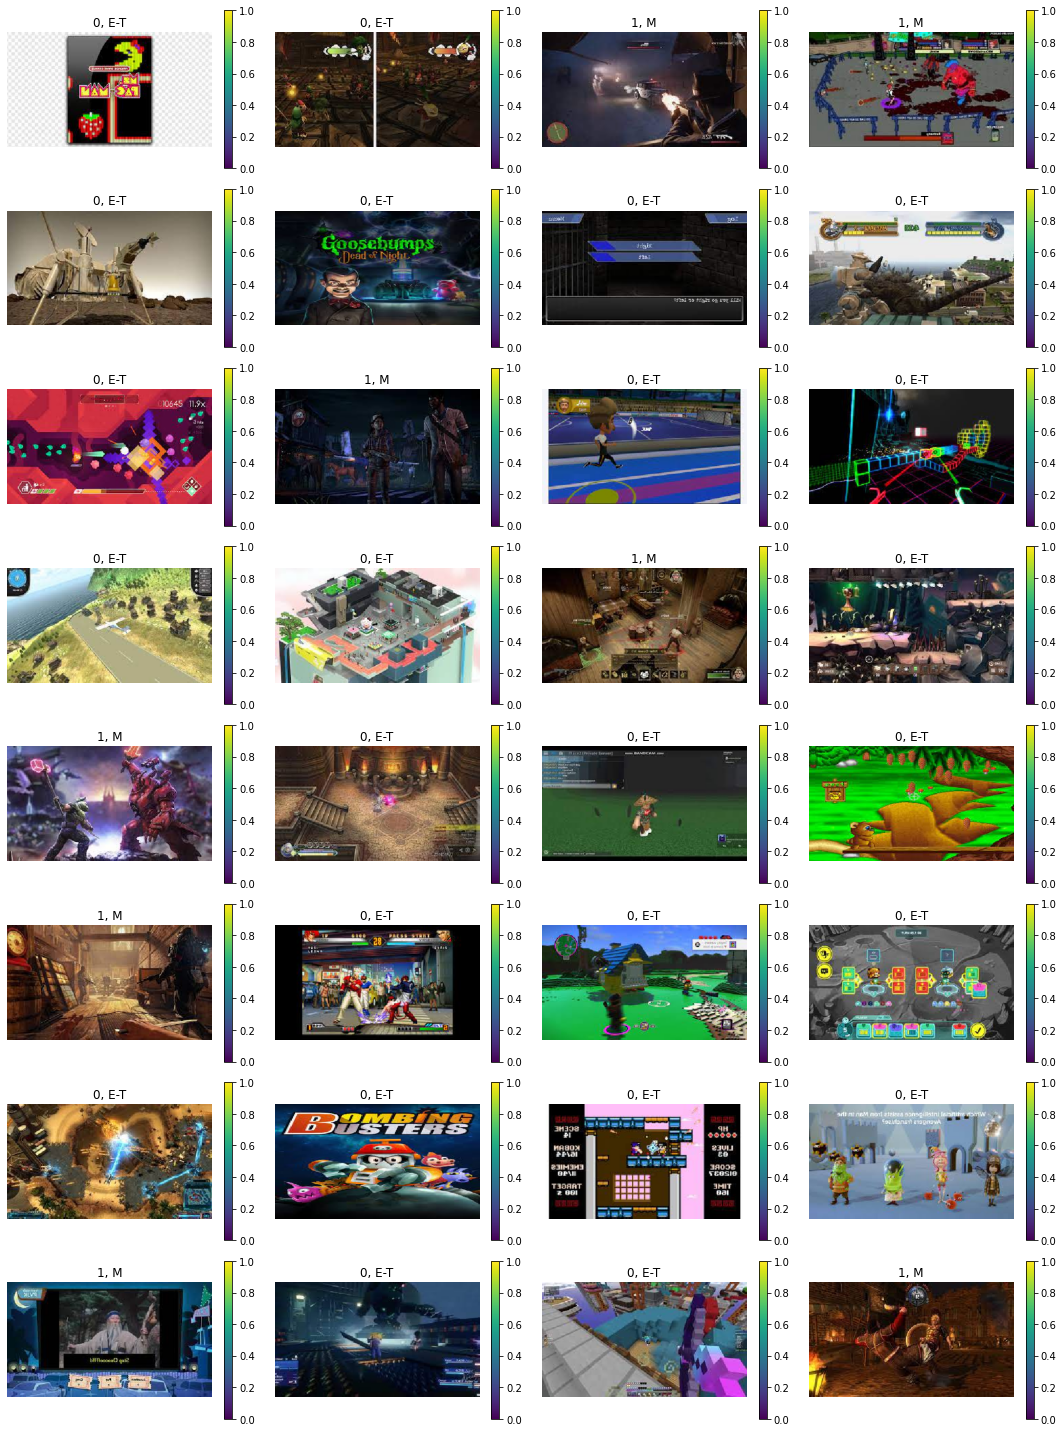

In [10]:
plt.figure(figsize=(15,20))
for i in range(len(img)):
    plt.subplot(8,4,i+1)
    plt.title(f'{int(labels[i])}, {str_labels[i]}')
    plt.imshow(img[i])
    plt.axis('off')
    plt.colorbar()
plt.tight_layout()

In [24]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same',
                 activation='relu', input_shape=(224,398,3)))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(512, (5,5), padding='same', activation='relu'))
model.add(Conv2D(512, (5,5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((4,4)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4)

model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 224, 398, 32)      896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 222, 396, 32)      9248      
_________________________________________________________________
batch_normalization_4 (Batch (None, 222, 396, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 198, 32)      0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 111, 198, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 111, 198, 64)      18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 109, 196, 64)     

In [25]:
class_counts = []
for i in range(2):
    class_counts.append(list(train_gen.classes).count(i))
class_counts

[26816, 6780]

In [26]:
weights = [max(class_counts)/x for x in class_counts]
weights

[1.0, 3.9551622418879058]

In [27]:
class_weight = {x:y for x,y in enumerate(weights)}
class_weight

{0: 1.0, 1: 3.9551622418879058}

In [28]:
history = model.fit(train_gen,
                    epochs=10,
                    validation_data=val_gen,
                    class_weight=class_weight)

Epoch 1/10
1050/1050 [==============================] - 381s 362ms/step - loss: 2.8779 - acc: 0.6101 - val_loss: 0.6275 - val_acc: 0.7121
Epoch 2/10
1050/1050 [==============================] - 381s 362ms/step - loss: 1.2803 - acc: 0.6706 - val_loss: 0.7920 - val_acc: 0.5629
Epoch 3/10
1050/1050 [==============================] - 380s 362ms/step - loss: 1.1890 - acc: 0.6828 - val_loss: 0.6486 - val_acc: 0.6679
Epoch 4/10
1050/1050 [==============================] - 380s 362ms/step - loss: 1.0821 - acc: 0.6851 - val_loss: 10.8692 - val_acc: 0.5732
Epoch 5/10
1050/1050 [==============================] - 380s 362ms/step - loss: 1.1070 - acc: 0.6900 - val_loss: 0.6864 - val_acc: 0.5853
Epoch 6/10
1050/1050 [==============================] - 380s 362ms/step - loss: 0.9604 - acc: 0.7020 - val_loss: 0.6790 - val_acc: 0.7554
Epoch 7/10
1050/1050 [==============================] - 381s 363ms/step - loss: 0.9281 - acc: 0.7180 - val_loss: 2.5932 - val_acc: 0.6786
Epoch 8/10
1050/1050 [===========

In [68]:
model.load_weights('binary_weights.h5')

281/281 [==============================] - 25s 90ms/step - loss: 0.5235 - acc: 0.8242
[0.5234636664390564, 0.8242444396018982]


C:\Users\katma\course_materials\capstone-project\my_module.py:19: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks(range(1,(len(history['acc']))+1),5)
C:\Users\katma\course_materials\capstone-project\my_module.py:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[1].set_xticks(range(1,(len(history['loss']))+1),5)


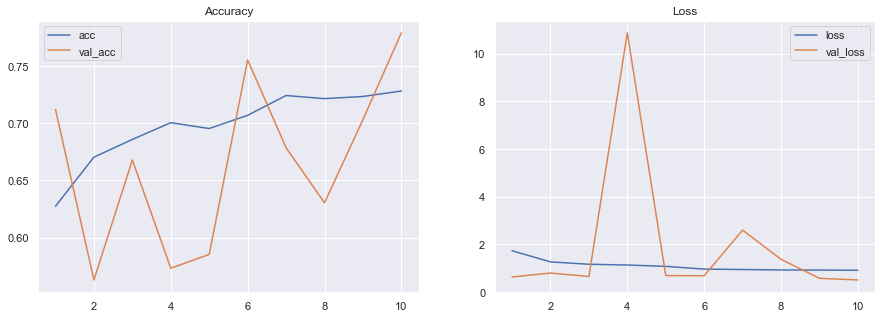

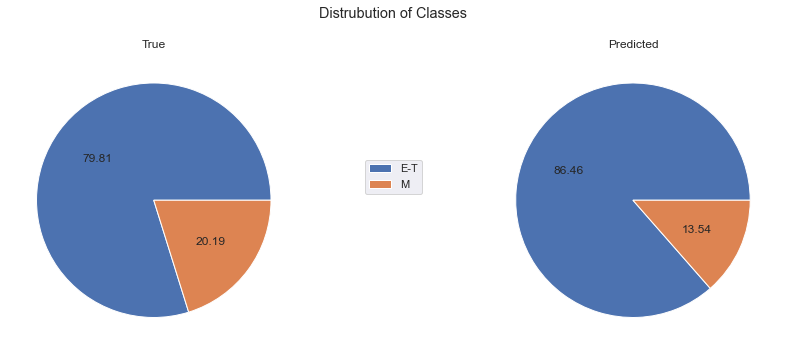

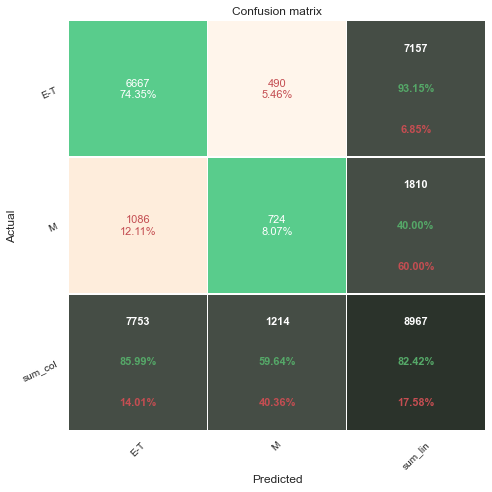

              precision    recall  f1-score   support

         E-T       0.86      0.93      0.89      7157
           M       0.60      0.40      0.48      1810

    accuracy                           0.82      8967
   macro avg       0.73      0.67      0.69      8967
weighted avg       0.81      0.82      0.81      8967



In [69]:
import importlib
importlib.reload(custom)
custom.evaluate(model, history, test_gen)

In [289]:
model.save_weights('binary_weights.h5')

In [82]:
from tensorflow.keras.applications import VGG16

In [99]:
base_model = VGG16(include_top=False,
                   input_shape=(224,398,3))
for layer in base_model.layers:
    layer.trainable=False

In [100]:
x = tf.keras.layers.Flatten()(base_model.output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 398, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 398, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 398, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 199, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 199, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 199, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 99, 128)       0   

In [101]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5',
                                                verbose=1,
                                                save_best_only=True,
                                                save_weights_only=True)

In [102]:
history2 = model.fit(train_gen,
                     epochs=10,
                     validation_data=val_gen,
                     class_weight=class_weight,
                     callbacks=checkpoint)

Epoch 1/10
1050/1050 [==============================] - 298s 283ms/step - loss: 1.1428 - acc: 0.6761 - val_loss: 0.5523 - val_acc: 0.7098

Epoch 00001: val_loss improved from inf to 0.55230, saving model to best_model.h5
Epoch 2/10
1050/1050 [==============================] - 298s 284ms/step - loss: 0.9315 - acc: 0.7267 - val_loss: 0.4833 - val_acc: 0.7683

Epoch 00002: val_loss improved from 0.55230 to 0.48330, saving model to best_model.h5
Epoch 3/10
1050/1050 [==============================] - 296s 282ms/step - loss: 0.9269 - acc: 0.7447 - val_loss: 0.5342 - val_acc: 0.7504

Epoch 00003: val_loss did not improve from 0.48330
Epoch 4/10
1050/1050 [==============================] - 296s 282ms/step - loss: 0.9090 - acc: 0.7546 - val_loss: 0.5317 - val_acc: 0.7451

Epoch 00004: val_loss did not improve from 0.48330
Epoch 5/10
1050/1050 [==============================] - 296s 282ms/step - loss: 0.9106 - acc: 0.7608 - val_loss: 0.5233 - val_acc: 0.7763

Epoch 00005: val_loss did not impro

281/281 [==============================] - 72s 255ms/step - loss: 0.5790 - acc: 0.7642
[0.5789883732795715, 0.7642467021942139]


C:\Users\katma\course_materials\capstone-project\my_module.py:19: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks(range(1,(len(history['acc']))+1),5)
C:\Users\katma\course_materials\capstone-project\my_module.py:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[1].set_xticks(range(1,(len(history['loss']))+1),5)


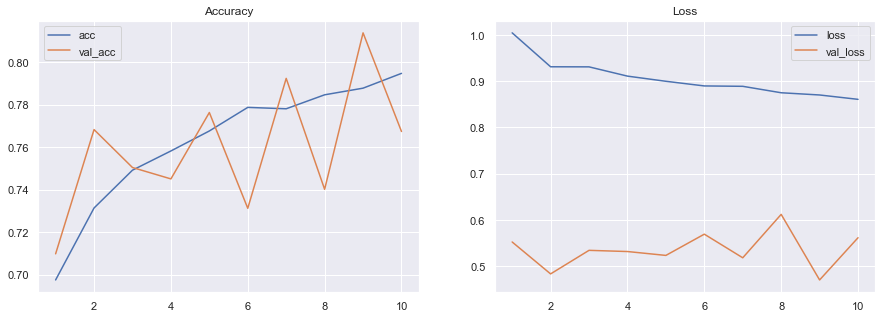

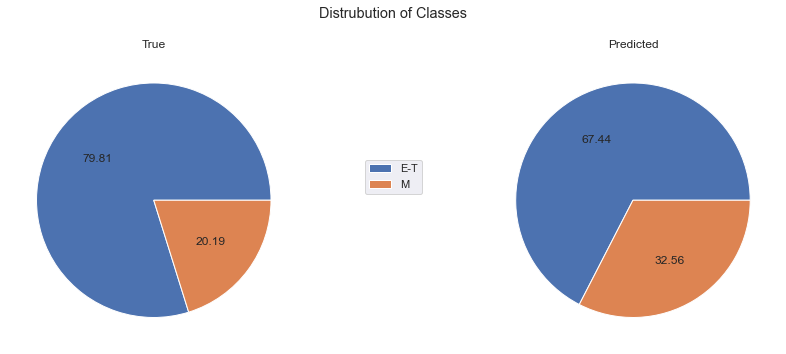

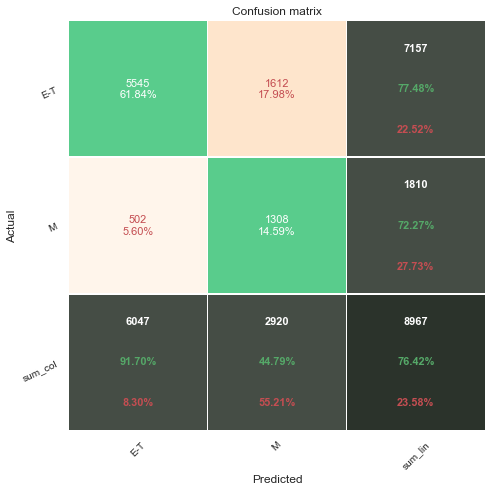

              precision    recall  f1-score   support

         E-T       0.92      0.77      0.84      7157
           M       0.45      0.72      0.55      1810

    accuracy                           0.76      8967
   macro avg       0.68      0.75      0.70      8967
weighted avg       0.82      0.76      0.78      8967



In [103]:
custom.evaluate(model, history2, test_gen)

281/281 [==============================] - 71s 254ms/step - loss: 0.4936 - acc: 0.8018
[0.4935874342918396, 0.801828920841217]


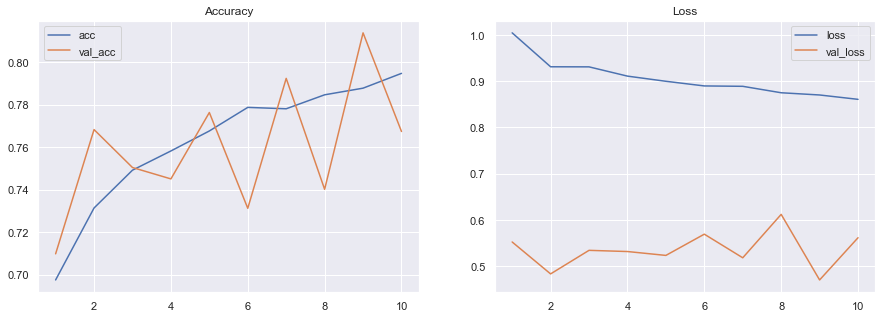

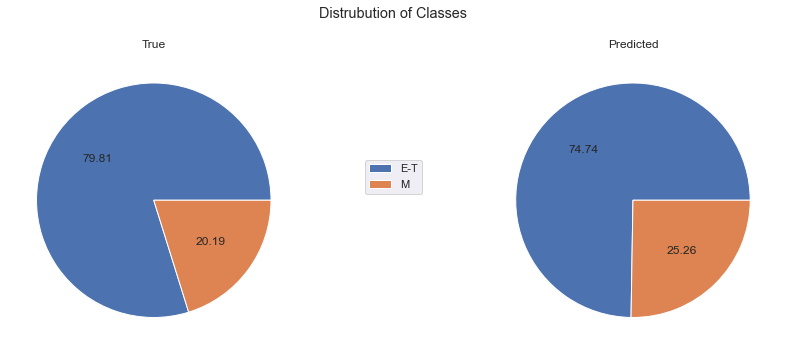

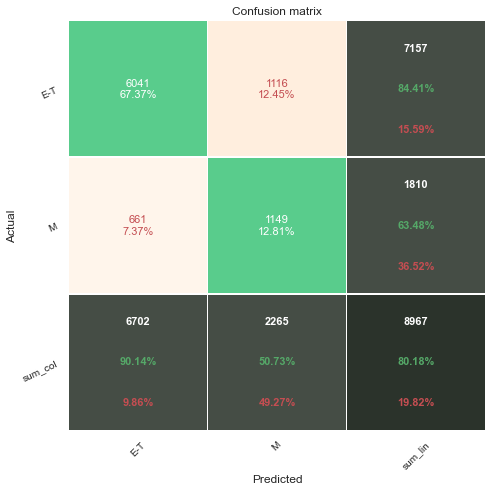

              precision    recall  f1-score   support

         E-T       0.90      0.84      0.87      7157
           M       0.51      0.63      0.56      1810

    accuracy                           0.80      8967
   macro avg       0.70      0.74      0.72      8967
weighted avg       0.82      0.80      0.81      8967



In [104]:
model.save_weights('last_model.h5')
model.load_weights('best_model.h5')
custom.evaluate(model, history2, test_gen)